# 百度网盘AI大赛——表格检测

基于TableNet得到表格的四个拐角坐标，本项目附带一个可以直接提交的样例。

[比赛链接](https://aistudio.baidu.com/aistudio/competition/detail/702/0/introduction)

# 1. 比赛介绍

生活中，扫描技术越来越常见，通过手机就能将图片转化为可编辑的文档等；但是现在的技术在处理带有表格类型的文字的时候往往没有那么灵敏，把完整表格拆分成难以使用的零散个体似乎很常见又令人苦恼。本次比赛旨在解决这个问题，通过万能的算法，准确地识别表格在图片中的位置并标注。

## 1.1. 数据介绍
本次比赛最新发布的数据集共包含训练集、A榜测试集、B榜测试集三个部分，其中训练集共10000张图片，A榜测试集共500张图片，B榜测试集500张图片；imgs目录下为所有训练图片；annos.txt 为标注文件，json格式，格式示例如下:

```
{
    "a.jpg": [  # 图片文件名称
        {
            'box': [xmin, ymin, xmax,ymax],  # 表格box位置，(xmin, ymin)为box左上点，(xmax, ymax)为box右下点
            'lb': [x, y],  # 表格left bottom点，即左下顶点
            'lt': [x, y],  # 表格left top点，即左上顶点
            'rt': [x, y],  # 表格right top点，即右上顶点
            'rb': [x, y]  # 表格right bottom点，即右下顶点
        }],
    
    "b.jpg": [{
        'box': [xmin, ymin, xmax, ymax],
        'lb': [x, y],
        'lt': [x, y],
        'rt': [x, y],
        'rb': [x, y]
    }]
}
```

## 1.2. 赛题分析

先用TableNet分析出各像素点属于表格内或外的概率，然后用resnet101回归得到四个角点的坐标，最后结果加以旋转。

# 2. 代码

## 2.1. 准备数据

In [1]:
! unzip -oq data/data182385/train.zip
! unzip -oq data/data182385/testA.zip

In [2]:
! pip3 install paddleclas

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


## 2.2. 创建数据读取器

In [3]:
import sys
sys.path.append('/home/aistudio/work/external-libraries')
import os
os.environ['FLAGS_eager_delete_tensor_gb'] = '0.0'

import paddle
# 设置CUDA训练
PLACE = paddle.CUDAPlace(0)
print(paddle.device.get_device())
paddle.device.set_device('gpu:0')

gpu:0


Place(gpu:0)

In [4]:
import json
import paddle
import os
import cv2
from paddle.vision.transforms import Compose, ColorJitter, Resize

class MyDateset(paddle.io.Dataset):
    def __init__(self, txt_dir = 'train/annos.txt', root_dir = 'train/imgs', mode = 'train'):
        super(MyDateset, self).__init__()

        self.mode = mode
        self.root_dir = root_dir
        with open('train/annos.txt', 'r') as f:
            self.data = json.load(f)
            self.name_list = list(self.data.keys())
    
    def __getitem__(self, index):
        name = self.name_list[index]
        img_dir = os.path.join(self.root_dir, name)

        img = cv2.imread(img_dir)
        # get img infor
        h, w, c = img.shape
        # pre-process of img
        img = paddle.vision.transforms.resize(img, (224,224), interpolation='bilinear')
        img = img.transpose((2,0,1))
        img = img/255
        img = paddle.to_tensor(img,place=PLACE).astype('float32')
        
        # pre-process of labels
        data = self.data[name][0] # get box infor
        labels = []
        for pos in ['lb','lt','rt','rb']:
            labels += [data[pos][0]/w, data[pos][1]/h] 
        labels = paddle.to_tensor(labels,place=PLACE).astype('float32')
        
        return img,labels

    def __len__(self):
        return len(self.name_list)
if 1:
    train_dataset=MyDateset('train.txt')

    train_dataloader = paddle.io.DataLoader(
        train_dataset,
        batch_size=48,
        shuffle=True,
        drop_last=False)

    for step, data in enumerate(train_dataloader):
        data, label = data
        print(step, data.shape, label.shape)
        print(label)
        break

W0301 11:57:20.661190 12305 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0301 11:57:20.664824 12305 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


0 [48, 3, 224, 224] [48, 8]
Tensor(shape=[48, 8], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.62980270, 0.99326771, 0.34839046, 0.98860693, 0.36552441, 0.00362506,
         0.64693666, 0.00828586],
        [0.57276505, 0.99594319, 0.30821207, 0.96450305, 0.42879418, 0.00608519,
         0.69334722, 0.03803245],
        [0.19203980, 0.98626715, 0.08159204, 0.83270913, 0.80796021, 0.01123596,
         0.91840798, 0.16479401],
        [0.29454544, 0.99448431, 0.10649350, 0.84390515, 0.70129871, 0.00551572,
         0.88935065, 0.15609486],
        [0.03175430, 0.98554915, 0.00416450, 0.68063581, 0.96616346, 0.01445087,
         0.99323267, 0.31936416],
        [0.37663016, 0.99519998, 0.27021387, 0.95359999, 0.62597811, 0.00586667,
         0.73239434, 0.04800000],
        [0.58649349, 0.99545455, 0.28935066, 0.96010101, 0.40987012, 0.00555556,
         0.70701301, 0.04090909],
        [0.47214854, 0.99469024, 0.41290894, 0.98761064, 0.53227234, 0.01238938,
         

In [5]:
# 先旋转图片
# 打个例子看看
import paddleclas
import matplotlib.pyplot as plt
img_dir='train/imgs/border_top_0_1ZEW823TRWOVKU3VYICU.jpg'
pre_model = paddleclas.PaddleClas(model_name="text_image_orientation")
result=pre_model.predict(input_data=img_dir)
img1=plt.imread(img_dir)
plt.imshow(img1)
plt.show()
# result = pre_model.predict(input_data="pulc_demo_imgs/text_image_orientation/img_rot0_demo.jpg")
a=float(next(result)[0]['label_names'][0])
print(a)

2023-03-01 11:57:22 INFO: Loading faiss with AVX2 support.
2023-03-01 11:57:22 INFO: Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
2023-03-01 11:57:22 INFO: Loading faiss.
2023-03-01 11:57:22 INFO: Successfully loaded faiss.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs f

<Figure size 640x480 with 1 Axes>

270.0


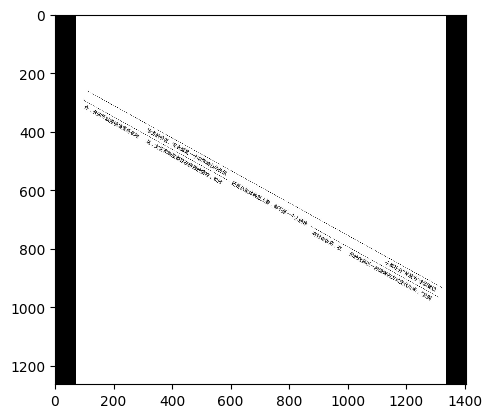

In [6]:
img2=cv2.imread(img_dir)
img2=paddle.vision.transforms.rotate(img2,a)
plt.imshow(img1)
plt.imshow(img2)

plt.show()

In [7]:
import random
random.seed(1234)
with open('train/annos.txt', 'r') as f:
    data = json.load(f)
    name_list = list(data.keys())
random.shuffle(name_list)
dev_name_list=name_list[:1000]
train_name_list=name_list[1000:]
# print(len(dev_name_list))

class MyDataset2(paddle.io.Dataset):
    def __init__(self, data, name_list, mode = 'train'):
        super(MyDataset2, self).__init__()

        self.mode = mode
        self.data=data
        self.name_list=name_list
        self.root_dir='train/imgs'

    def __getitem__(self, index):

        name = self.name_list[index]
        img_dir = os.path.join(self.root_dir, name)
        # res=pre_model.predict(input_data=img_dir)
        # angle=float(next(res)[0]['label_names'][0])
        
        img = cv2.imread(img_dir)
        # get img infor
        h, w, c = img.shape
        # pre-process of img
        # img=paddle.vision.transforms.rotate(img,angle)
        img = paddle.vision.transforms.resize(img, (224,224), interpolation='bilinear')
        img = img.transpose((2,0,1))
        img = img/255
        img = paddle.to_tensor(img,place=PLACE).astype('float32')
        
        # pre-process of labels
        data = self.data[name][0] # get box infor
        labels = []
        for pos in ['lb','lt','rt','rb']:
            labels += [data[pos][0]/w, data[pos][1]/h] 
        labels = paddle.to_tensor(labels,place=PLACE).astype('float32')
        
        return img,labels

    def __len__(self):
        return len(self.name_list)

if 1:
    train_dataset=MyDataset2(data,train_name_list)
    dev_dataset=MyDataset2(data,dev_name_list)
    #print(len(train_dataset))
    train_dataloader = paddle.io.DataLoader(
        train_dataset,
        batch_size=100,
        shuffle=True,
        drop_last=False)
    dev_dataloader=paddle.io.DataLoader(
        dev_dataset,
        batch_size=100,
        shuffle=False,
        drop_last=False)
    #print('1')

    for step, data in enumerate(train_dataloader):
        # print('1')
        #print(step)
        data, label= data
        print(step, data.shape, label.shape)
        break

0 [100, 3, 224, 224] [100, 8]


## 2.3. 构建网络
对于表格问题，可以用TableNet进行处理。

In [8]:
import paddle
import paddle.vision.models as models
import paddle.nn as nn
import paddle.nn.functional as F
class DenseNet(nn.Layer):
    def __init__(self, pretrained = True, requires_grad = True):
        super(DenseNet, self).__init__()
        #denseNet=models.densenet161(pretrained=True).children()
        denseNet = list(models.densenet121(pretrained=True).children())
        self.densenet_out_1 = nn.Sequential()
        self.densenet_out_2 = nn.Sequential()
        self.densenet_out_3 = nn.Sequential()
        # densenet的结构和torch不一样
        for x in range(6):
            self.densenet_out_1.add_sublayer(str(x), denseNet[x])
        for x in range(6,8):
            self.densenet_out_2.add_sublayer(str(x), denseNet[x])

        self.densenet_out_3.add_sublayer(str(8), denseNet[8])

        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):

        out_1 = self.densenet_out_1(x) #torch.Size([1, 256, 14, 14])
        out_2 = self.densenet_out_2(out_1) #torch.Size([1, 512, 7, 7])
        out_3 = self.densenet_out_3(out_2) #torch.Size([1, 1024, 7, 7])
        # print(out_1.shape,out_2.shape,out_3.shape)
        return out_1, out_2, out_3

In [9]:
# densenet=list(models.densenet121(pretrained=True).children())
# print(len(densenet))
# for i in range(len(densenet)):
#     print('{}:{}'.format(i,densenet[i]))

In [10]:
class TableDecoder(nn.Layer):
    def __init__(self, channels, kernels, strides):
        super(TableDecoder, self).__init__()
        self.conv_7_table = nn.Conv2D(  #卷积结果有sigma运算
                        in_channels = 256,
                        out_channels = 256,
                        kernel_size = kernels[0],
                        stride = strides[0])
        self.upsample_1_table = nn.Conv2DTranspose(
                        in_channels = 256,
                        out_channels=128,
                        kernel_size = kernels[1],
                        stride = strides[1])
        self.upsample_2_table = nn.Conv2DTranspose(
                        in_channels = 128 + channels[0],
                        out_channels = 256,
                        kernel_size = kernels[2],
                        stride = strides[2])
        self.upsample_3_table = nn.Conv2DTranspose(
                        in_channels = 256 + channels[1],
                        out_channels = 3,
                        kernel_size = 16,
                        stride = 16)

    def forward(self, x, pool_3_out, pool_4_out):
        #print(x.shape)
        x = self.conv_7_table(x)  #[1, 256, 7, 7]
        #print(x.shape)
        out = self.upsample_1_table(x) #[1, 128, 7, 7]
        #print(out.shape)
        out = paddle.concat((out, pool_4_out), 1) #[1, 32, 7, 7]
        #print(out.shape)
        out = self.upsample_2_table(out) #[1, 256, 14,14]
        #print(out.shape)
        out = paddle.concat((out, pool_3_out), 1) #[1, 512, 14, 14]
        #print(out.shape)
        out = self.upsample_3_table(out) #[1, 3, 224, 224]
        #print(out.shape)
        return out

In [11]:
class TableNet(nn.Layer):
    def __init__(self):
        super(TableNet, self).__init__()

        self.base_model = DenseNet(pretrained = False, requires_grad = True)
        self.pool_channels = [512, 256]
        self.in_channels = 1024
        self.kernels = [(1,1), (1,1), (2,2),(16,16)]
        self.strides = [(1,1), (1,1), (2,2),(16,16)]

        #common layer
        self.conv6 = nn.Sequential(
            nn.Conv2D(in_channels = self.in_channels, out_channels = 256, kernel_size=(1,1)),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Conv2D(in_channels = 256, out_channels = 256, kernel_size=(1,1)),
            nn.ReLU(),
            nn.Dropout(0.8))

        self.table_decoder = TableDecoder(self.pool_channels, self.kernels, self.strides)
        self.resnet=models.resnet101(pretrained=True,num_classes=0)
        self.fc =nn.Linear(in_features=2048, out_features=8)

    def forward(self, x):

        pool_3_out, pool_4_out, pool_5_out = self.base_model(x)
        conv_out = self.conv6(pool_5_out) #[1, 256, 7, 7]
        #print(conv_out.shape)
        table_out = self.table_decoder(conv_out, pool_3_out, pool_4_out) #torch.Size([1,3,224,224])
        #print(table_out.shape)
        
        table_out=self.resnet(table_out) #[1,2048,1,1]，值是0到1之间的概率
        table_out = paddle.flatten(table_out,1)
        table_out = self.fc(table_out)
        return table_out

#paddle.summary(TableNet(),(128, 3, 1024, 1024))

## 2.4. 训练

In [12]:
# import paddle
# mse_loss = paddle.nn.loss.MSELoss()
# input_ = paddle.to_tensor([1,1.2,1,1])
# label = paddle.to_tensor([3.1,2,2,2])
# print(input_,label)
# output = paddle.nn.functional.mse_loss(input_, label)
# print(output.item())
import numpy as np
a=[1,2.0]
print(type(np.mean(a).item()))

<class 'float'>


In [13]:
import matplotlib.pyplot as plt
import numpy as np
now_step=0
class Runner():
    def __init__(self,model,opt,train_dataloader,dev_dataloader):
        self.now_step=0
        self.train_loss=[]
        self.dev_loss=[]
        self.model=model
        #self.loss_fn=loss_fn
        self.opt=opt
        self.train_dataloader=train_dataloader
        self.dev_dataloader=dev_dataloader
        self.least_loss=999999
    def train_on_epoch(self):
    
        if 1:
            try:
                # 接续之前的模型重复训练
                param_dict = paddle.load('./model.pdparams')
                self.model.load_dict(param_dict)
            except:
                print('no such model file')
        for step, data in enumerate(self.train_dataloader):
            
            img, label = data
            pre = self.model(img)
            # pre[pre>=0.3]=1
            # pre[pre<0.3]=0
            # pre=pre.transpose((0,2,3,1))
            # pre = pre.numpy()
            # prediction=[]
            # for i in range(len(pre)):
            #     pre_i=pre[i]
            #     pre_i = cv2.cvtColor(pre_i,cv2.COLOR_RGB2GRAY)
            #     plt.imshow(pre_i)
            #     # print(pre_i.shape)
            #     pre_i=cv2.goodFeaturesToTrack(pre_i,4,0.001,10)
            #     # print(pre_i)
            #     pre_i=paddle.to_tensor(pre_i,place=PLACE)
            #     prediction.append(pre_i.reshape([8]))
            # prediction=paddle.to_tensor(prediction,place=PLACE)
            loss = paddle.nn.functional.mse_loss(pre, label)
            self.train_loss.append(loss.item())
            loss.backward()
            self.opt.step()
            self.opt.clear_gradients()
            if self.now_step%10==0:
                print("[Train]epoch: {}, batch: {}, loss is: {:.5f}".format(epoch, self.now_step, loss.item()))
            if self.now_step%20==0:
                self.test_on_epoch()
            self.now_step+=1

    def test_on_epoch(self):
        self.model.eval()
        loss_sum=[]
        with paddle.no_grad():
            for step, data in enumerate(self.dev_dataloader):
                img, label= data
                pre = self.model(img)
                
                loss = paddle.nn.functional.mse_loss(pre, label)
                loss_sum.append(loss.item())
            loss_sum=np.mean(loss_sum)
            self.dev_loss.append(loss_sum.item())
            print("[Dev]epoch: {}, step: {}, dev_loss is: {:.5f}".format(epoch, self.now_step, loss_sum.item()))
            if loss_sum.item()<self.least_loss:                    
                paddle.save(model.state_dict(), 'model.pdparams')
                print('[Update]least loss has been updated: {:.5f}-->{:.5f}'.format(self.least_loss,loss_sum.item()))
                self.least_loss=loss_sum.item()
        self.model.train()
    # 可视化
    def plot_loss(self,fig_name='tableNet.pdf', fig_size=(8, 5), loss_legend_loc="upper right"):
        plt.figure(figsize=fig_size)
        train_items =self.train_loss[::4]
        train_steps=[x for x in range(len(train_items))]
        train_losses = [x for x in train_items]
        plt.plot(train_steps, train_losses, color='#e4007f', label="Train loss")
        dev_items =self.dev_loss[::2]
        dev_steps=[x for x in range(len(dev_items))]
        dev_losses = [x for x in dev_items]
        plt.plot(dev_steps, dev_losses, color='#f19ec2', linestyle='--', label='Dev loss')
        #绘制坐标轴和图例
        plt.ylabel("loss", fontsize='large')
        plt.xlabel("step", fontsize='large')
        plt.legend(loc=loss_legend_loc, fontsize='x-large')
        
        plt.savefig(fig_name)
        plt.show()

In [14]:
model=TableNet()
max_epoch=3
opt = paddle.optimizer.Adam(learning_rate=0.001, beta1=0.9, beta2=0.999, parameters= model.parameters()) 
runner=Runner(model,opt,train_dataloader,dev_dataloader)
for epoch in range(max_epoch):
    runner.train_on_epoch()

2023-03-01 11:57:33 INFO: unique_endpoints {''}
2023-03-01 11:57:33 INFO: File /home/aistudio/.cache/paddle/hapi/weights/DenseNet121_pretrained.pdparams md5 checking...
2023-03-01 11:57:33 INFO: Found /home/aistudio/.cache/paddle/hapi/weights/DenseNet121_pretrained.pdparams
2023-03-01 11:57:33 INFO: unique_endpoints {''}
2023-03-01 11:57:33 INFO: File /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams md5 checking...
2023-03-01 11:57:34 INFO: Found /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:654: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


[Train]epoch: 0, batch: 0, loss is: 0.03040
[Dev]epoch: 0, step: 0, dev_loss is: 0.83512
[Update]least loss has been updated: 999999.00000-->0.83512
[Train]epoch: 0, batch: 10, loss is: 0.04833
[Train]epoch: 0, batch: 20, loss is: 0.01619
[Dev]epoch: 0, step: 20, dev_loss is: 0.12162
[Update]least loss has been updated: 0.83512-->0.12162
[Train]epoch: 0, batch: 30, loss is: 0.01014
[Train]epoch: 0, batch: 40, loss is: 0.00542
[Dev]epoch: 0, step: 40, dev_loss is: 0.03589
[Update]least loss has been updated: 0.12162-->0.03589
[Train]epoch: 0, batch: 50, loss is: 0.00509
[Train]epoch: 0, batch: 60, loss is: 0.00681
[Dev]epoch: 0, step: 60, dev_loss is: 0.00771
[Update]least loss has been updated: 0.03589-->0.00771
[Train]epoch: 0, batch: 70, loss is: 0.00771
[Train]epoch: 0, batch: 80, loss is: 0.00388
[Dev]epoch: 0, step: 80, dev_loss is: 0.01427
[Train]epoch: 1, batch: 90, loss is: 0.00495
[Train]epoch: 1, batch: 100, loss is: 0.00552
[Dev]epoch: 1, step: 100, dev_loss is: 0.01359
[Tra

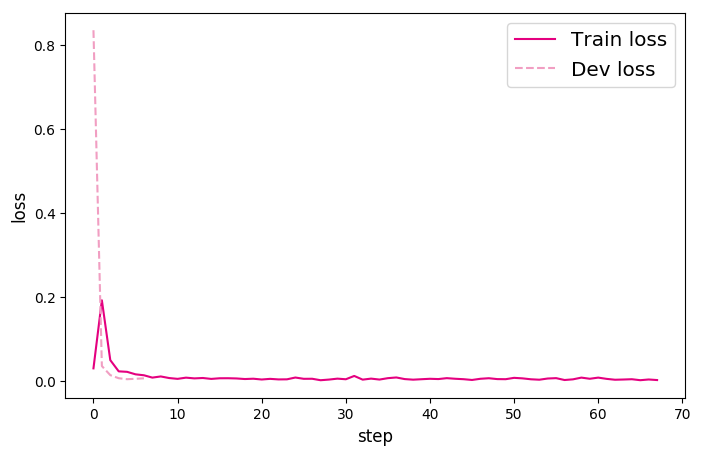

In [15]:
runner.plot_loss()

In [16]:
# #from utils.metrics import compute_metrics
# model = TableNet()
# #print('here 3')
# model.train()

# if 1:
#     try:
#         # 接续之前的模型重复训练
#         param_dict = paddle.load('./model.pdparams')
#         model.load_dict(param_dict)
#     except:
#         print('no such model file')

# train_dataset=MyDateset()
# train_dataloader = paddle.io.DataLoader(
#     train_dataset,
#     batch_size=100,
#     shuffle=True,
#     drop_last=False)

# max_epoch=10
# # scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.01, T_max=max_epoch)
# opt = paddle.optimizer.Adam(learning_rate=0.1, beta1=0.9, beta2=0.999, parameters= model.parameters()) 
# now_step=0
# table_loss=[]
# for epoch in range(max_epoch):
#     for step, data in enumerate(train_dataloader):
#         now_step+=1

#         img, label = data
#         pre = model(img)
#         loss = paddle.nn.functional.mse_loss(pre, label).mean()
#         table_loss.append(loss.item())
#         loss.backward()
#         opt.step()
#         opt.clear_gradients()
#         if now_step%20==0:
#             print("epoch: {}, batch: {}, loss is: {}".format(epoch, step, loss.mean().numpy()))

# paddle.save(model.state_dict(), 'model.pdparams')

In [17]:
# paddle.save(model.state_dict(), 'model.pdparams')

## 2.5. 保存

In [18]:
# 保存
model = TableNet()
param_dict = paddle.load('./model.pdparams')
model.load_dict(param_dict)
model.eval()

paddle.jit.save(
    layer=model,
    path='mymodel/model',
    input_spec=[paddle.static.InputSpec(shape=[None, 3, 1024, 1024], dtype='float32')])

2023-03-01 12:15:49 INFO: unique_endpoints {''}
2023-03-01 12:15:49 INFO: File /home/aistudio/.cache/paddle/hapi/weights/DenseNet121_pretrained.pdparams md5 checking...
2023-03-01 12:15:49 INFO: Found /home/aistudio/.cache/paddle/hapi/weights/DenseNet121_pretrained.pdparams
2023-03-01 12:15:49 INFO: unique_endpoints {''}
2023-03-01 12:15:49 INFO: File /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams md5 checking...
2023-03-01 12:15:50 INFO: Found /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/math_op_patch.py:341: UserWarning: /opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/vision/models/resnet.py:167
The behavior of expression A + B has been unified with elementwise_add(X, Y, axis=-1) from Paddle 2.0. If your code works well in the older versions but crashes in this version, try to use elementwise_add(X, Y, axis=0) instead of A + B. This transition

## 2.6. 准备predict.py文件

predict.py文件内容如下

```
# 代码示例
# python predict.py [src_image_dir] [results]

import os
import sys
import glob
import json
import cv2
import paddle


def process(src_image_dir, save_dir):
    # load
    model = paddle.jit.load('./mymodel/model')
    model.eval()

    image_paths = glob.glob(os.path.join(src_image_dir, "*.jpg"))
    result = {}
    for image_path in image_paths:
        filename = os.path.split(image_path)[1]
        # do something
        img = cv2.imread(image_path)
        # get img infor
        h, w, c = img.shape
        # pre-process of img
        img = paddle.vision.transforms.resize(img, (512,512), interpolation='bilinear')
        img = img.transpose((2,0,1))
        img = img/255
        img = paddle.to_tensor(img).astype('float32')
        img = paddle.reshape(img, [1]+img.shape)

        pre = model(img)
        pre = pre[0]
        pre[pre>1]=1
        pre[pre<0]=0
        pre = pre.tolist()
        x1, y1, x2, y2, x3, y3, x4, y4 = pre
        x1, x2, x3, x4 = [int(x*w) for x in [x1, x2, x3, x4]]
        y1, y2, y3, y4 = [int(y*h) for y in [y1, y2, y3, y4]]

        xmin = min(x1,x2,x3,x4)
        xmax = max(x1,x2,x3,x4)
        ymin = min(y1,y2,y3,y4)
        ymax = max(y1,y2,y3,y4)

        if filename not in result:
            result[filename] = []
        result[filename].append({
            "box": [xmin, ymin, xmax, ymax],
            "lb": [x1, y1],
            "lt": [x2, y2],
            "rt": [x3, y3],
            "rb": [x4, y4],
        })
    with open(os.path.join(save_dir, "result.txt"), 'w', encoding="utf-8") as f:
        f.write(json.dumps(result))


if __name__ == "__main__":
    assert len(sys.argv) == 3

    src_image_dir = sys.argv[1]
    save_dir = sys.argv[2]

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    process(src_image_dir, save_dir)
```

In [19]:
# 运行代码查看预测结果
! python predict.py pubtest/imgs test_A_result

2023-03-01 12:16:01 INFO: Loading faiss with AVX2 support.
2023-03-01 12:16:01 INFO: Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
2023-03-01 12:16:01 INFO: Loading faiss.
2023-03-01 12:16:01 INFO: Successfully loaded faiss.


## 2.7. 打包提交

In [20]:
! zip -r submit.zip predict.py mymodel

updating: predict.py (deflated 59%)
updating: mymodel/ (stored 0%)
updating: mymodel/model.pdmodel (deflated 98%)
updating: mymodel/model.pdiparams.info (deflated 85%)
updating: mymodel/model.pdiparams (deflated 7%)


# 3. 总结

本项目先用TableNet分析出特征图，即每个像素属于表格内、表格外的概率，然后用resnet101回归，学习到四个角点的坐标。在predict.py文件中，根据图片对结果进行了旋转。

检测模型具体可以参考[百度网盘AI大赛——表格检测进阶：表格的结构化 Baseline](https://aistudio.baidu.com/aistudio/projectdetail/5234267)

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 